# 4.10. 实战Kaggle比赛：预测房价

## 4.10.1. 下载和缓存数据集

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

"""
首先，我们建立字典DATA_HUB， 它可以将数据集名称的字符串映射到数据集相关的二元组上， 这个二元组包含数据集的url和验证文件完整性的sha-1密钥。 所有类似的数据集都托管在地址为DATA_URL的站点上。
"""
#@save
DATA_HUB=dict()
DATA_URL='http://d2l-data.s3-accelerate.amazonaws.com/'

"""
下面的download函数用来下载数据集， 将数据集缓存在本地目录（默认情况下为../data）中， 并返回下载文件的名称。 如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配， 我们将使用缓存的文件，以避免重复的下载。
"""
#@save
def download(name,cache_dir=os.path.join('/media/zhangzq/Disk0/dataset/d2l','data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f'{name} not exist in {DATA_HUB}'
    url,sha1_hash=DATA_HUB[name]
    os.makedirs(cache_dir,exist_ok=True)
    fname=os.path.join(cache_dir,url.split('/')[-1])

    if os.path.exists(fname):
        sha1=hashlib.sha1()
        with open(fname,'rb') as f:
            while True:
                data=f.read(1048576)
                if not data:
                    break
        if sha1.hexdigest()==sha1_hash:
            return fname  # 命中缓存

    print(f'正在从{url}下载{fname}...')
    r=requests.get(url,stream=True,verify=True)
    with open(fname,'wb') as f:
        f.write(r.content)
    return fname

"""
下载并解压zip/tar文件
"""
#@save
def download_extract(name,folder=None):
    fname=download(name)
    base_dir=os.path.dirname(fname)
    data_dir,ext=os.path.splitext(fname)

    if ext=='.zip':
        fp=zipfile.ZipFile(fname,'r')
    elif ext in ('.tar','.gz'):
        fp=tarfile.open(fname,'r')
    else:
        assert False , '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir,folder) if folder else data_dir

"""
下载DATA_HUB中的所有文件
"""
#@save
def download_all():
    for name in DATA_HUB:
        download(name)


## 4.10.2. Kaggle
[Kaggle](https://www.kaggle.com/)是一个当今流行举办机器学习比赛的平台， 每场比赛都以至少一个数据集为中心。

## 4.10.3. 访问和读取数据集

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

"""
使用上面定义的脚本下载并缓存Kaggle房屋数据集。
"""
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

"""
使用pandas分别加载包含训练数据和测试数据的两个CSV文件。
"""
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

"""
训练数据集包括1460个样本，每个样本80个特征和1个标签， 而测试数据集包含1459个样本，每个样本80个特征。
"""
train_data.shape,test_data.shape

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载/media/zhangzq/Disk0/dataset/d2l/data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载/media/zhangzq/Disk0/dataset/d2l/data/kaggle_house_pred_test.csv...


((1460, 81), (1459, 80))

In [5]:
type(train_data)

pandas.core.frame.DataFrame

In [22]:
"""
看看前四个和最后两个特征，以及相应标签（房价）。
"""
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [23]:
"""
我们可以看到，在每个样本中，第一个特征是ID， 这有助于模型识别每个训练样本。 虽然这很方便，但它不携带任何用于预测的信息。 因此，在将数据提供给模型之前，我们将其从数据集中删除。
"""
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

## 4.10.4. 数据预处理

如上所述，我们有各种各样的数据类型。在开始建模之前，我们需要对数据进行预处理。首先，我们**将所有缺失的值替换为相应特征的平均值**。然后，为了将所有特征放在一个共同的尺度上，我们**通过将特征重新缩放到零均值和单位方差来标准化数据**：

$$x \leftarrow \frac{x - \mu}{\sigma},$$

其中$\mu$和$\sigma$分别表示均值和标准差。现在，这些特征具有零均值和单位方差，即 $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$和$E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$。直观地说，我们标准化数据有两个原因：首先，它方便优化。其次，因为我们不知道哪些特征是相关的，所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。

In [24]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [25]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,RM,-2.069222,-1.043758,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.078492,-1.363335,WD,Normal
1455,2.419286,RM,-2.069222,-1.049083,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.815205,-1.363335,WD,Abnorml
1456,-0.873466,RL,3.884968,1.246594,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,-1.363335,WD,Abnorml
1457,0.655311,RL,-0.312950,0.034599,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,MnPrv,Shed,1.144116,0.289865,-1.363335,WD,Normal


接下来，我们**处理离散值**。这包括诸如“MSZoning”之类的特征。**我们用独热编码替换它们**，方法与前面将多类别标签转换为向量的方式相同（请参见3.4.1节）。例如，“MSZoning”包含值“RL”和“Rm”。我们将创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。根据独热编码，如果“MSZoning”的原始值为“RL”，则：“MSZoning_RL”为1，“MSZoning_RM”为0。`pandas`软件包会自动为我们实现这一点。

In [26]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [27]:
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [28]:
"""
可以看到此转换会将特征的总数量从79个增加到331个。

最后，通过values属性，我们可以 从pandas格式中提取NumPy格式，并将其转换为张量表示用于训练。
"""
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [30]:
train_features,train_labels

(tensor([[ 0.0673, -0.1844, -0.2178,  ...,  1.0000,  0.0000,  0.0000],
         [-0.8735,  0.4581, -0.0720,  ...,  1.0000,  0.0000,  0.0000],
         [ 0.0673, -0.0559,  0.1372,  ...,  1.0000,  0.0000,  0.0000],
         ...,
         [ 0.3025, -0.1416, -0.1428,  ...,  1.0000,  0.0000,  0.0000],
         [-0.8735, -0.0559, -0.0572,  ...,  1.0000,  0.0000,  0.0000],
         [-0.8735,  0.2439, -0.0293,  ...,  1.0000,  0.0000,  0.0000]]),
 tensor([[208500.],
         [181500.],
         [223500.],
         ...,
         [266500.],
         [142125.],
         [147500.]]))

## 4.10.5. 训练
首先，我们训练一个带有损失平方的线性模型。 显然线性模型很难让我们在竞赛中获胜，但线性模型提供了一种健全性检查， 以查看数据中是否存在有意义的信息。 如果我们在这里不能做得比随机猜测更好，那么我们很可能存在数据处理错误。 如果一切顺利，线性模型将作为基线（baseline）模型， 让我们直观地知道最好的模型有超出简单的模型多少。

In [31]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。因此，**我们更关心相对误差$\frac{y - \hat{y}}{y}$**，而不是绝对误差$y - \hat{y}$。例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时，假设我们的预测偏差了10万美元，然而那里一栋典型的房子的价值是12.5万美元，那么模型可能做得很糟糕。另一方面，如果我们在加州豪宅区的预测出现同样的10万美元的偏差，（在那里，房价中位数超过400万美元）这可能是一个不错的预测。

**解决这个问题的一种方法是用价格预测的对数来衡量差异**。事实上，这也是比赛中官方用来评价提交质量的误差指标。即将$\delta$ for $|\log y - \log \hat{y}| \leq \delta$转换为$e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$。这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$

In [32]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

"""
与前面的部分不同，我们的训练函数将借助Adam优化器 （我们将在后面章节更详细地描述它）。 Adam优化器的主要吸引力在于它对初始学习率不那么敏感。
"""
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## 4.10.6. K折交叉验证
本书在讨论模型选择的部分（[4.4节](../chap4_MultilayerPerceptron(MLP)/L4_4_模型选择、欠拟合和过拟合.ipynb)） 中介绍了K折交叉验证， 它有助于模型选择和超参数调整。 我们首先需要定义一个函数，在$K$折交叉验证过程中返回第$i$折的数据。 具体地说，它选择第$i$个切片作为验证数据，其余部分作为训练数据。 注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，会有其他解决办法。

In [33]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

"""
当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值。
"""
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 4.10.7. 模型选择
在本例中，我们选择了一组未调优的超参数，并将其留给读者来改进模型。 找到一组调优的超参数可能需要时间，这取决于一个人优化了多少变量。 有了足够大的数据集和合理设置的超参数，折交叉验证往往对多次测试具有相当的稳定性。 然而，如果我们尝试了不合理的超参数，我们可能会发现验证效果不再代表真正的误差。

折1，训练log rmse0.169754, 验证log rmse0.156721
折2，训练log rmse0.162461, 验证log rmse0.192062
折3，训练log rmse0.163748, 验证log rmse0.168685
折4，训练log rmse0.168133, 验证log rmse0.154529
折5，训练log rmse0.163349, 验证log rmse0.182961
5-折验证: 平均训练log rmse: 0.165489, 平均验证log rmse: 0.170992


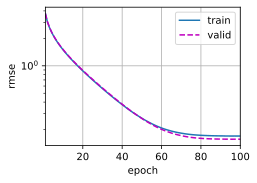

In [34]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

请注意，有时一组超参数的训练误差可能非常低，但K折交叉验证的误差要高得多， 这表明模型过拟合了。 在整个训练过程中，你将希望监控训练误差和验证误差这两个数字。 较少的过拟合可能表明现有数据可以支撑一个更强大的模型，较大的过拟合可能意味着我们可以通过正则化技术来获益。

## 4.10.8. 提交你的Kaggle预测
既然我们知道应该选择什么样的超参数， 我们不妨使用所有数据对其进行训练 （而不是仅使用交叉验证中使用的$1-1/K$的数据）。 然后，我们通过这种方式获得的模型可以应用于测试集。 将预测保存在CSV文件中可以简化将结果上传到Kaggle的过程。

训练log rmse：0.162421


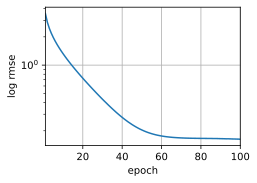

In [35]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

"""
如果测试集上的预测与K倍交叉验证过程中的预测相似， 那就是时候把它们上传到Kaggle了。 下面的代码将生成一个名为submission.csv的文件。
"""
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)



## 4.10.9. 小结
- 真实数据通常混合了不同的数据类型，需要进行预处理。
- 常用的预处理方法：**将实值数据重新缩放为零均值和单位方法**；**用均值替换缺失值**。
- 将类别特征转化为指标特征，可以使我们把这个特征当作一个**独热向量**来对待。
- 我们可以使用K折交叉验证来选择模型并调整超参数。
- **对数对于相对误差很有用**。